In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


In [2]:
!pip install --quiet --no-cache-dir scikit-learn==1.5.2 imbalanced-learn==0.12.3 xgboost==2.1.1 lightgbm==4.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 269.1 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 336.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 257.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 273.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


## Install the libraries

In [3]:
# Import the remaining library
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
from sklearn.preprocessing import LabelEncoder,StandardScaler
import warnings
warnings.filterwarnings('ignore')

## Data Processing and Cleaning it.

In [4]:
# Load the train_data and test data
sub_file=pd.read_csv('/kaggle/input/playground-series-s5e11/sample_submission.csv')
test_df=pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')
train_df=pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
train_df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [5]:
# Create a function to do the same basic data preprocessing steps

def preprocessing_steps(df):

    # checking the null values
    null_values= df.isna().sum()
    print(f'{null_values}\n')

    # Checking the duplicated values
    duplicate_values=df.duplicated().sum()
    print(f'The data contains {duplicate_values} duplicate values \n')
    
    # Shape of the data set
    print(f'The data have {df.shape[0]} rows and {df.shape[1]} columns \n')

    # data columns information
    df.info()

# Apply the above function to the traing dataset
preprocessing_steps(train_df)

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

The data contains 0 duplicate values 

The data have 593994 rows and 13 columns 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-n

In [6]:
# Some basics statics 
train_df.describe().style.background_gradient(cmap='gist_rainbow_r')

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,296996.500000,48212.202976,0.120696,680.916009,15020.297629,12.356345,0.798820
std,171471.442235,26711.942078,0.068573,55.424956,6926.530568,2.008959,0.400883
min,0.000000,6002.430000,0.011000,395.000000,500.090000,3.200000,0.000000
25%,148498.250000,27934.400000,0.072000,646.000000,10279.620000,10.990000,1.000000
50%,296996.500000,46557.680000,0.096000,682.000000,15000.220000,12.370000,1.000000
75%,445494.750000,60981.320000,0.156000,719.000000,18858.580000,13.680000,1.000000
max,593993.000000,393381.740000,0.627000,849.000000,48959.950000,20.990000,1.000000


##  Explore Data Analysis Process (EDA)
* >Basic Explore Data Analysis process i do what is the average loan amount of each genders
* > Which education is most of the people are done.
* > Gender distribution and Loan payback prediction using the pie chart.

In [8]:
# Average loan amount for each category
avg_loan_amount=pd.DataFrame(train_df.groupby('gender')['loan_amount'].mean().sort_values(ascending=False))
avg_loan_amount

,loan_amount
gender,
Female,15043.360083
Male,14996.142716
Other,14966.930161


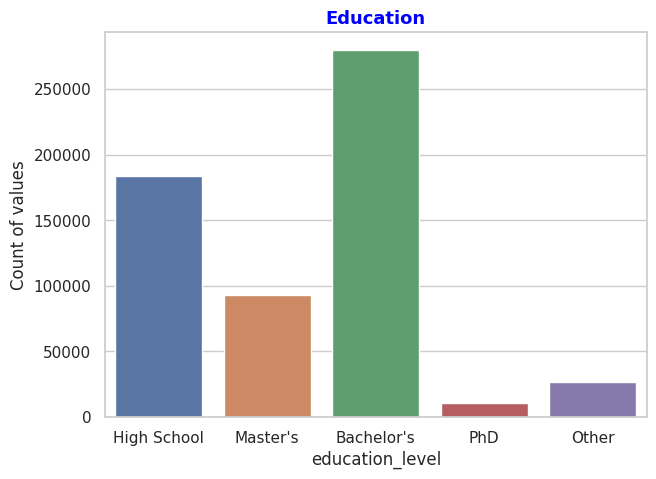

In [9]:
# Display the education in the barplots.
plt.figure(figsize=(7,5))
sns.set_theme(style='whitegrid')
plt.title("Education",fontsize=13,fontweight='bold',color='blue')
sns.countplot(train_df,x='education_level')
plt.ylabel('Count of values')
plt.show()

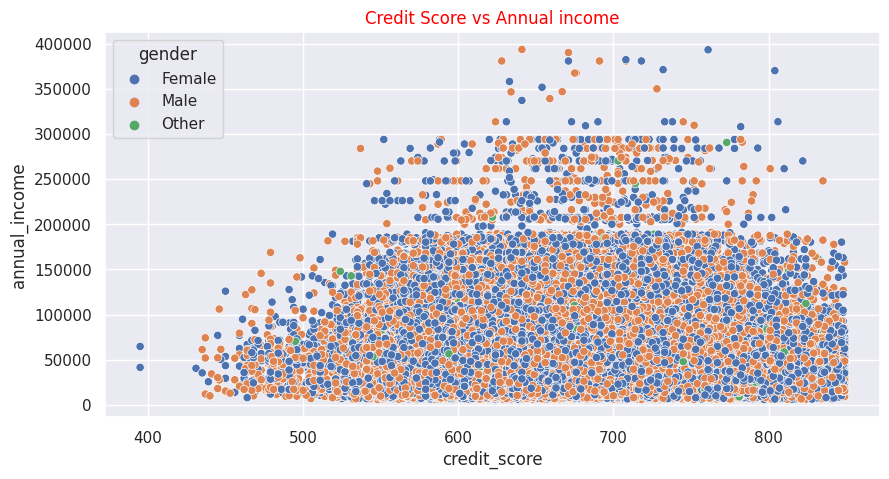

In [10]:
# Scatter plot the credit score and annual income
sns.set_theme(style='darkgrid')
plt.figure(figsize=(10,5))
sns.scatterplot(train_df,x='credit_score',y='annual_income',hue='gender')
plt.title("Credit Score vs Annual income",fontsize=12,color='red')
plt.show()

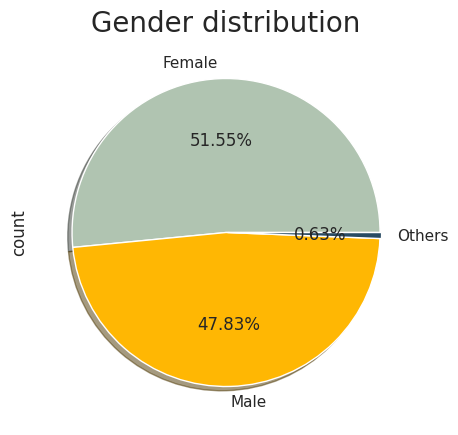

In [11]:
#Gender distribution 
plt.figure(figsize=(10,5))
train_df['gender'].value_counts().sort_values(ascending=False)\
.plot(kind='pie',explode=[0,0,0.01],
    labels=['Female','Male','Others'],
    colors=['#b0c4b1','#ffb703','#284b63'],
    autopct='%1.2f%%',
    pctdistance=0.6,
    shadow=True)
plt.title('Gender distribution',fontsize=20)
plt.show()

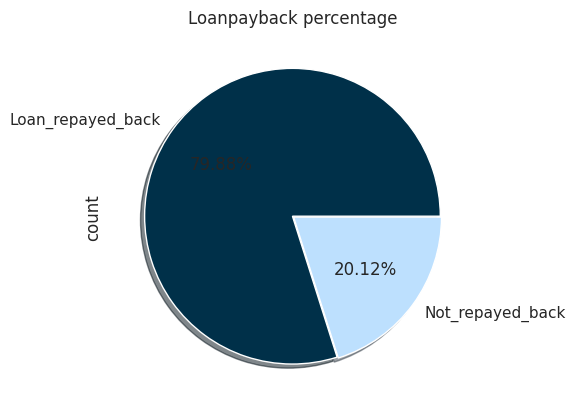

In [12]:
# Checking the dataset is balanced or imbalanced
train_df['loan_paid_back'].value_counts().sort_values(ascending=False)\
.plot(kind='pie',
    explode=[0,0.01],
    labels=['Loan_repayed_back','Not_repayed_back'],
    colors=['#003049','#bde0fe'],
    autopct='%1.2f%%',
    pctdistance=0.6,
    shadow=True)
plt.title('Loanpayback percentage')
plt.show()

## Feature Engineer Process

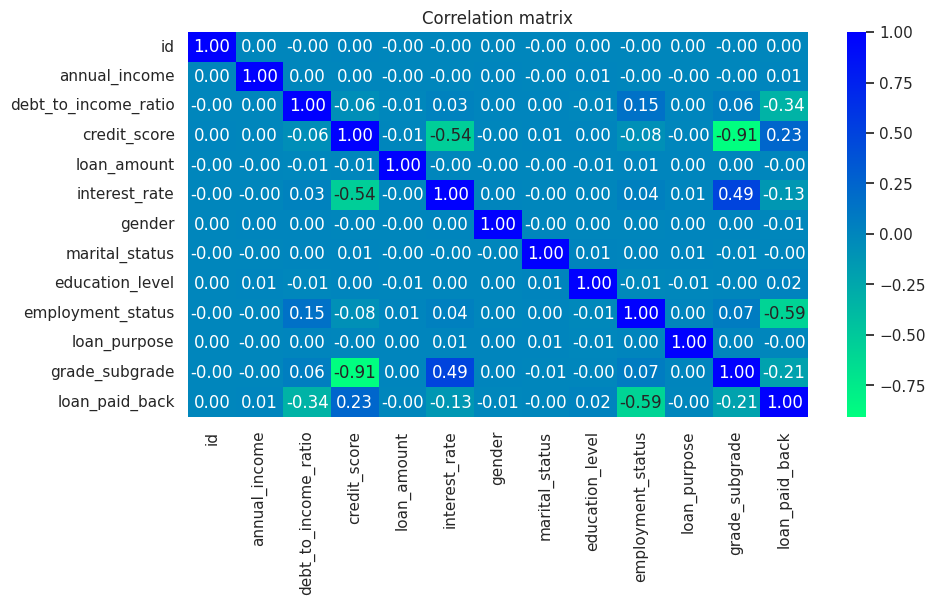

In [13]:
# Label Encoding fuction to convert the categorical columns to numerical
def label_encoding(df):
    label=LabelEncoder()
    # fit and transform the data
    return label.fit_transform(df)

# Let's seperate the categorical columns
cat=train_df.select_dtypes(include='object')

# using the loop convert the categorical columns to numerical
for col in cat.columns:
    train_df[col]=label_encoding(train_df[col])

# Checking the correlation matrix
plt.figure(figsize=(10,5))
correlation=train_df.corr()
sns.heatmap(correlation,annot=True,fmt='.2f',cmap='winter_r')
plt.title("Correlation matrix")
plt.show()

## Building a Machine Learning Model

LogisticRegression() accuracy score is 0.8896894928585378 

              precision    recall  f1-score   support

         0.0       0.84      0.56      0.67     30014
         1.0       0.90      0.97      0.93    118485

    accuracy                           0.89    148499
   macro avg       0.87      0.77      0.80    148499
weighted avg       0.89      0.89      0.88    148499
 



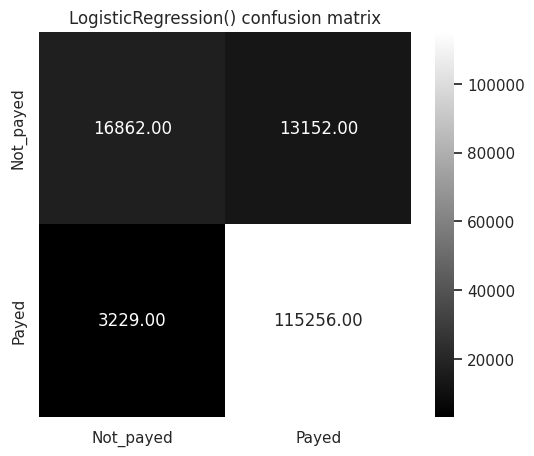

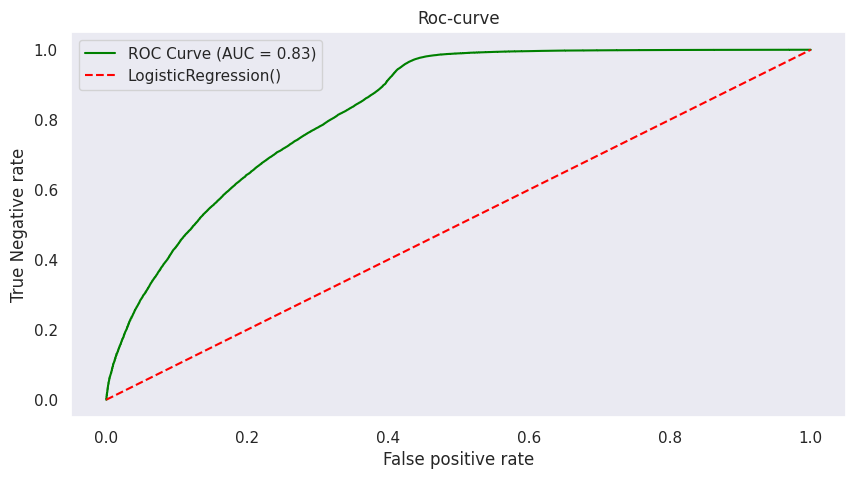

In [14]:
# Let's drop the correlation columns
train_corr=train_df.drop('grade_subgrade',axis=1)


# Split the dataset into X and y
X=train_corr.iloc[:,1:11]
y=train_corr.iloc[:,-1]

# Split the data into the train_test 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

# Let's create a machine learning model

def machine_learning_model(model,X_train,X_test,y_train,y_test):

    # fit the model
    model.fit(X_train,y_train)

    # Prediction of the model
    model_pred=model.predict(X_test)

   #Accuray score
    score=accuracy_score(y_test,model_pred)
    print(f'{model} accuracy score is {score} \n')

   # Classification report 
    class_repo=classification_report(y_test,model_pred)
    print(f'{class_repo} \n')

   # Confusion_matrix
    cn_matrix=confusion_matrix(y_test,model_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cn_matrix,annot=True,fmt='.2f',cmap='gist_yarg_r',xticklabels=['Not_payed','Payed'],yticklabels=['Not_payed','Payed'])
    plt.title(f'{model} confusion matrix')
    plt.show()


    # Roc Curve
    # Predict the probabilities of the model
    model_pred_roc=model.predict_proba(X_test)[:,1]
    # Compute the ROC curve
    fpr,rpr,threshlod=roc_curve(y_test,model_pred_roc)

    # Compute the AUC curve
    roc_auc=auc(fpr,rpr)

    # plot the figure
    plt.figure(figsize=(10,5))
    plt.plot(fpr,rpr,label=f"ROC Curve (AUC = {roc_auc:.2f})",color='green')
    plt.plot([0,1],[0,1],color='red',linestyle='--', label=f'{model}')
    plt.title('Roc-curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True Negative rate')
    plt.legend()
    plt.grid()
    plt.show()


# Apply the Logistic Regression model

logistic=LogisticRegression(penalty='l2',solver='lbfgs')
# Finally apply the logistic model
machine_learning_model(logistic,X_train,X_test,y_train,y_test)

### AdaBoost Classifier Algorithm

AdaBoostClassifier(n_estimators=100, random_state=0) accuracy score is 0.9011845197610758 

              precision    recall  f1-score   support

         0.0       0.85      0.62      0.72     30014
         1.0       0.91      0.97      0.94    118485

    accuracy                           0.90    148499
   macro avg       0.88      0.80      0.83    148499
weighted avg       0.90      0.90      0.90    148499
 



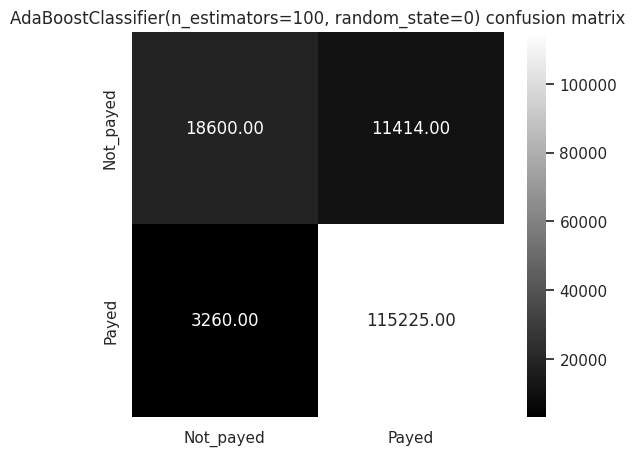

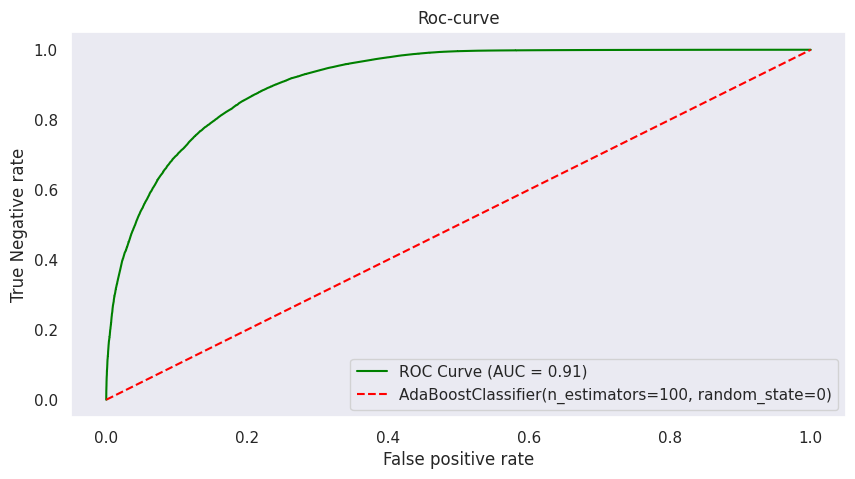

In [15]:
# AdaboostClassifier algorithms
ada_boost=AdaBoostClassifier(n_estimators=100, random_state=0)

# Finally apply the adam model
machine_learning_model(ada_boost,X_train,X_test,y_train,y_test)


### DecisionTree Classifier algorithm

DecisionTreeClassifier(criterion='entropy', max_depth=3) accuracy score is 0.8968679923770531 

              precision    recall  f1-score   support

         0.0       0.89      0.56      0.69     30014
         1.0       0.90      0.98      0.94    118485

    accuracy                           0.90    148499
   macro avg       0.90      0.77      0.81    148499
weighted avg       0.90      0.90      0.89    148499
 



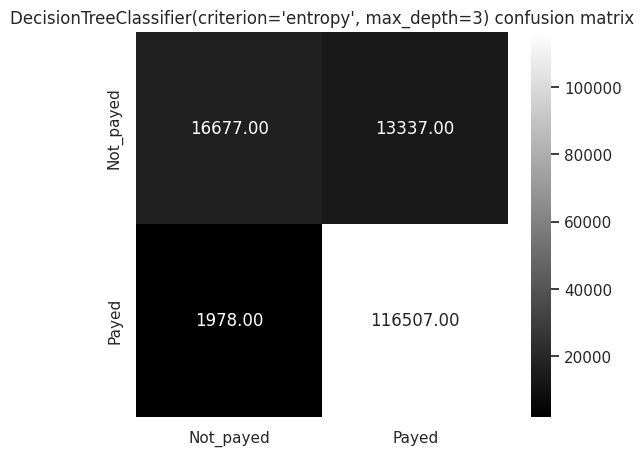

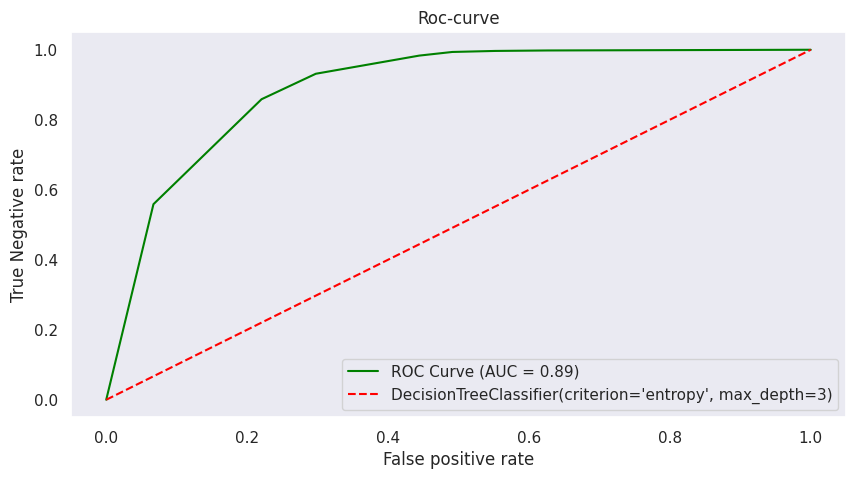

In [16]:

# Apply the DecisionTree model

tree=DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=3)
# Finally apply the DecisionTree model
machine_learning_model(tree,X_train,X_test,y_train,y_test)

### XGB Classifier algorithm

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...) accuracy score is 0.9037434595519162 

              precision    recall  f1-score   support

         0.0       0.88      0.61      0.72     30014
         1.0       0.91      0.98      0.94    118485

    accuracy                           0.9

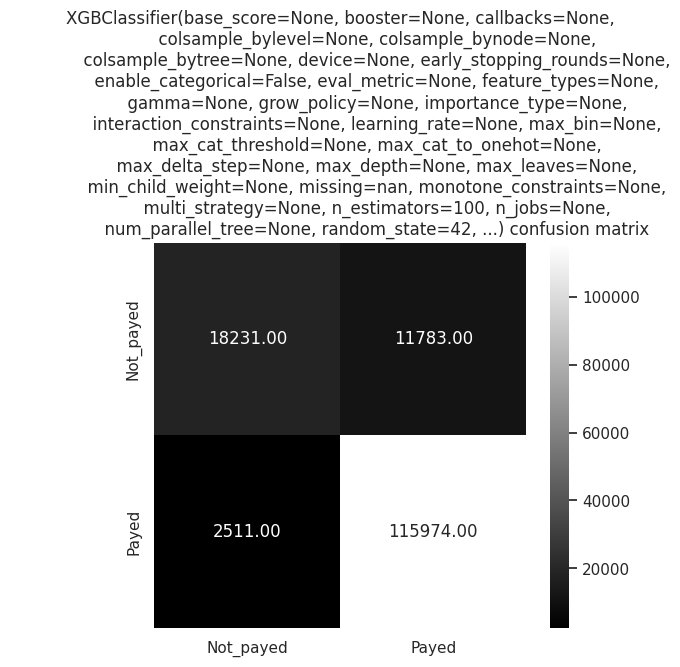

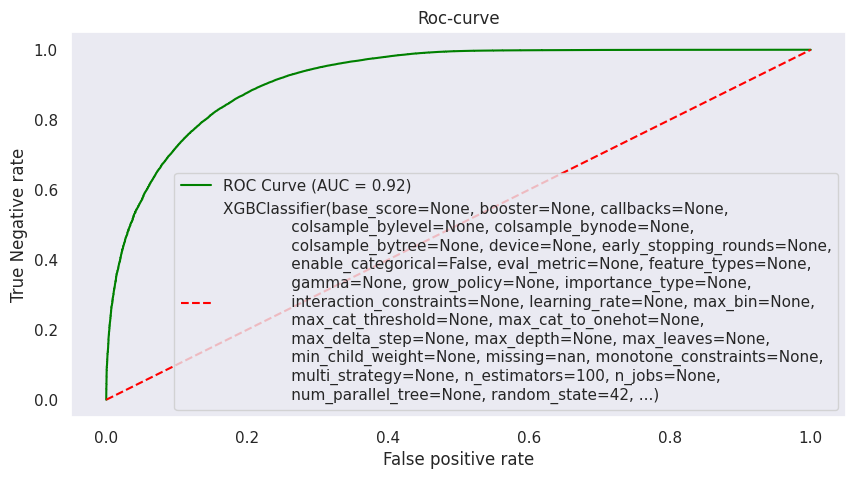

In [17]:
from xgboost import XGBClassifier
xgb_model=XGBClassifier(n_estimators=100,random_state=42)
# XGB Model
machine_learning_model(xgb_model,X_train,X_test,y_train,y_test)

### RandomForest Classifier Algorithm

RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=50) accuracy score is 0.8921070175556738 

              precision    recall  f1-score   support

         0.0       0.96      0.49      0.65     30014
         1.0       0.88      0.99      0.94    118485

    accuracy                           0.89    148499
   macro avg       0.92      0.74      0.79    148499
weighted avg       0.90      0.89      0.88    148499
 



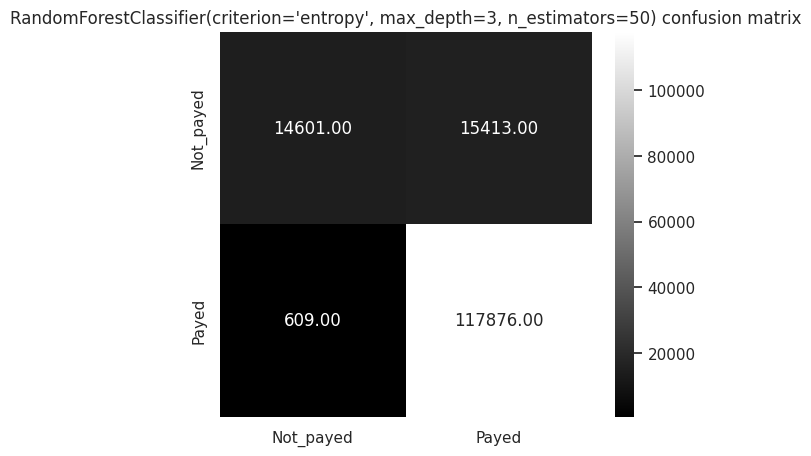

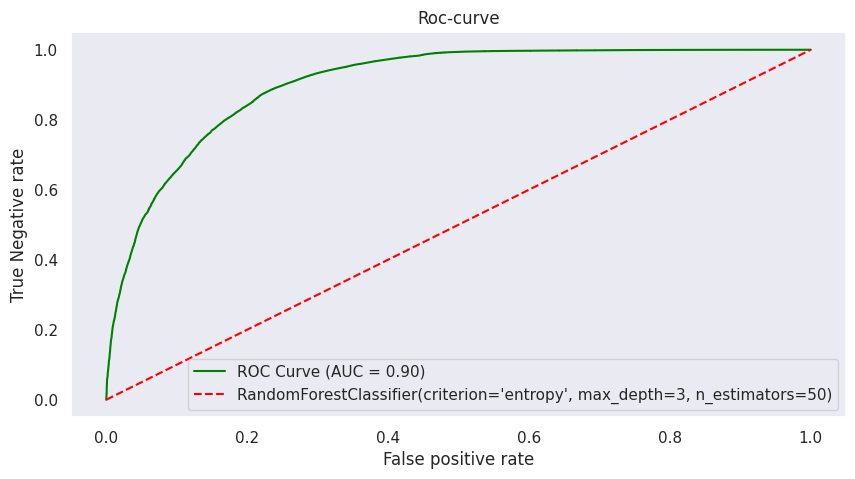

In [18]:
# Apply the RandomForestClassifier

random=RandomForestClassifier(n_estimators=50,
    criterion='entropy',
    max_depth=3)
# Finally apply the Random Forest model
machine_learning_model(random,X_train,X_test,y_train,y_test)

### Voting classifier algorithm

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            max_cat_to_onehot=None,
    

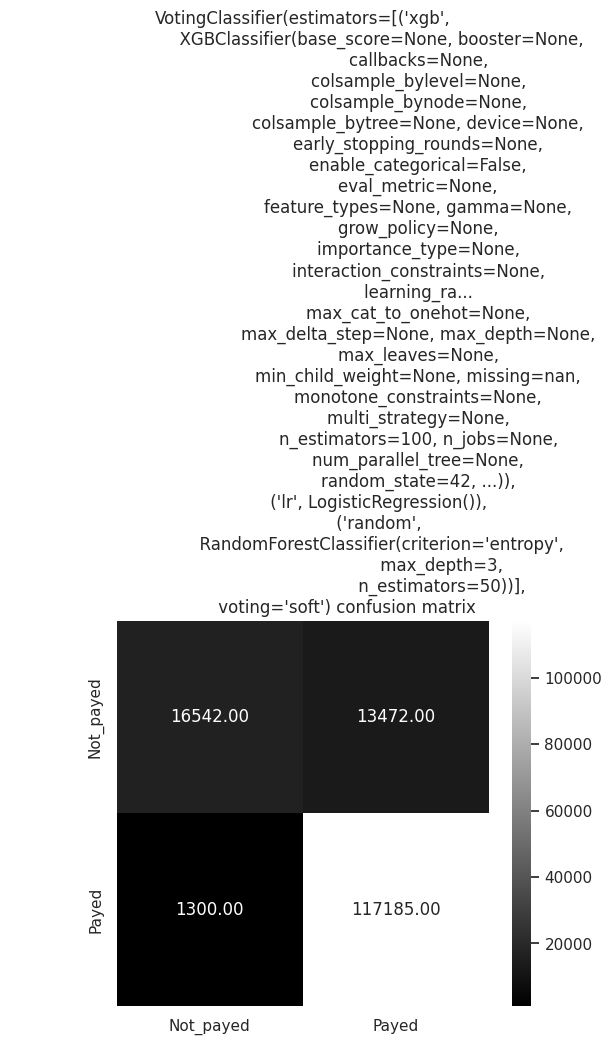

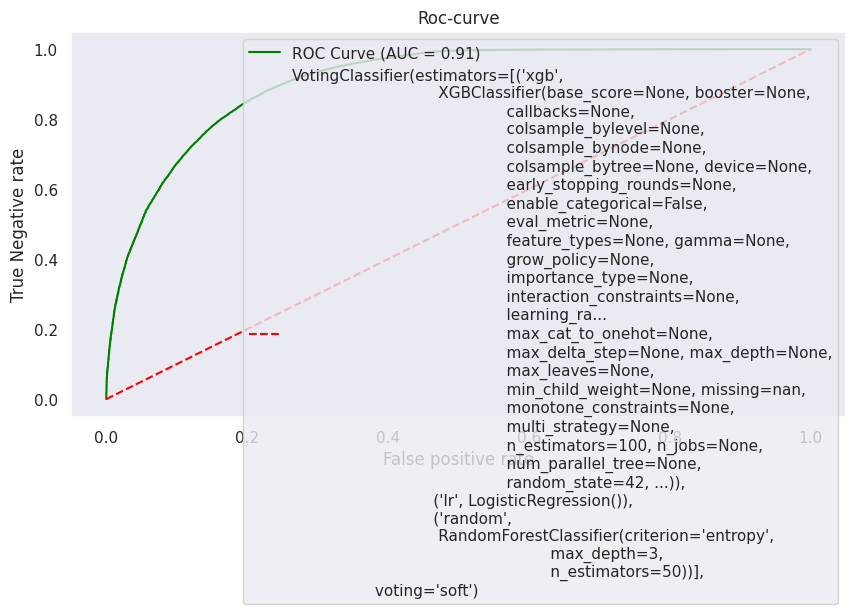

In [19]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(
    estimators=[ ('xgb', xgb_model), ('lr', logistic),('random',random)],
    voting='soft'
)

# Finally apply the VotingClassifer model
machine_learning_model(voting_model,X_train,X_test,y_train,y_test)

## Find the prediction for the test dataset and submit it to our hackathons.

In [22]:

# Remove the correaltion columns and id values
test_corr=test_df.drop(['id','grade_subgrade'],axis=1)


# separate the categorical columns
test_cat=test_corr.select_dtypes(include='object')

for col in test_cat.columns:
    test_corr[col]=label_encoding(test_corr[col])

# prediction of the test data
test_pred=xgb_model.predict(test_corr)

# apply to the submission files

sub_file['loan_paid_back']=test_pred

# Save the file in csv format

sub_file.to_csv('submision_xgb_grid.csv',index=False)

In [23]:
# prediction of the test data
test_pred=voting_model.predict(test_corr)

# apply to the submission files

sub_file['loan_paid_back']=test_pred

# Save the file in csv format

sub_file.to_csv('submision_voting_over_model.csv',index=False)

## Imbalanced Techniques

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...) accuracy score is 0.8526522064121644 

              precision    recall  f1-score   support

         0.0       0.61      0.74      0.67     30014
         1.0       0.93      0.88      0.91    118485

    accuracy                           0.8

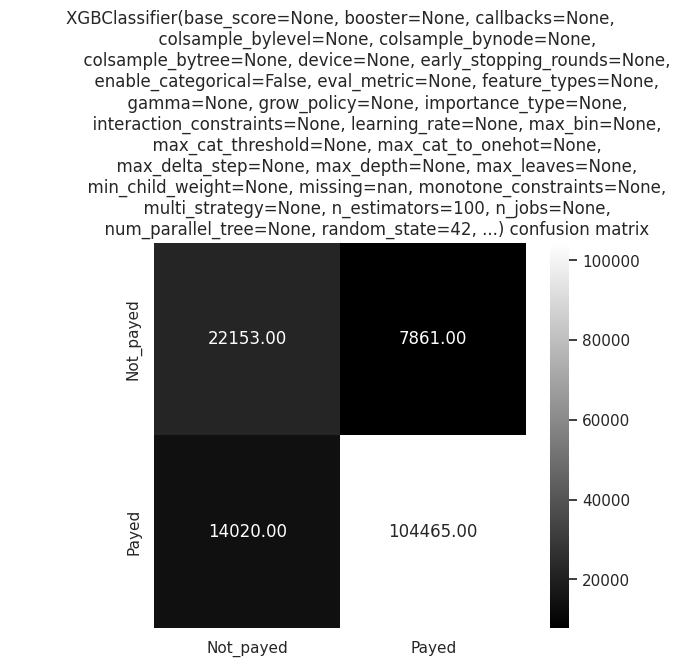

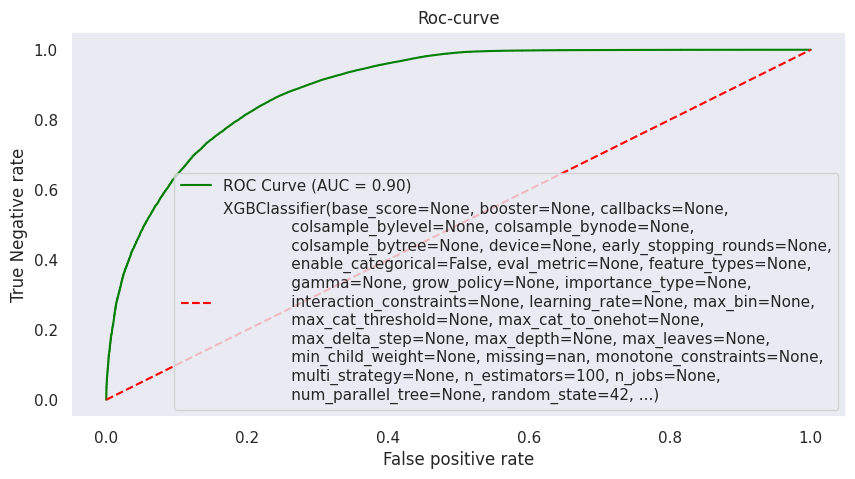

In [24]:
from imblearn.over_sampling import SMOTE
smote=SMOTE()
X_res,y_res=smote.fit_resample(X_train,y_train)
# Finally apply the VotingClassifer model
machine_learning_model(xgb_model,X_res,X_test,y_res,y_test)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            max_cat_to_onehot=None,
    

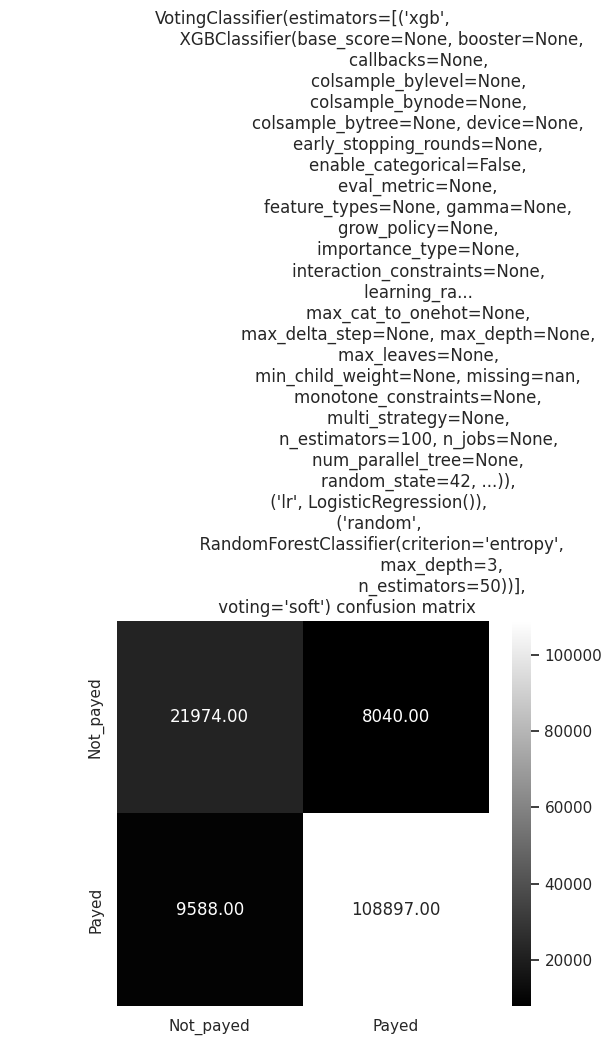

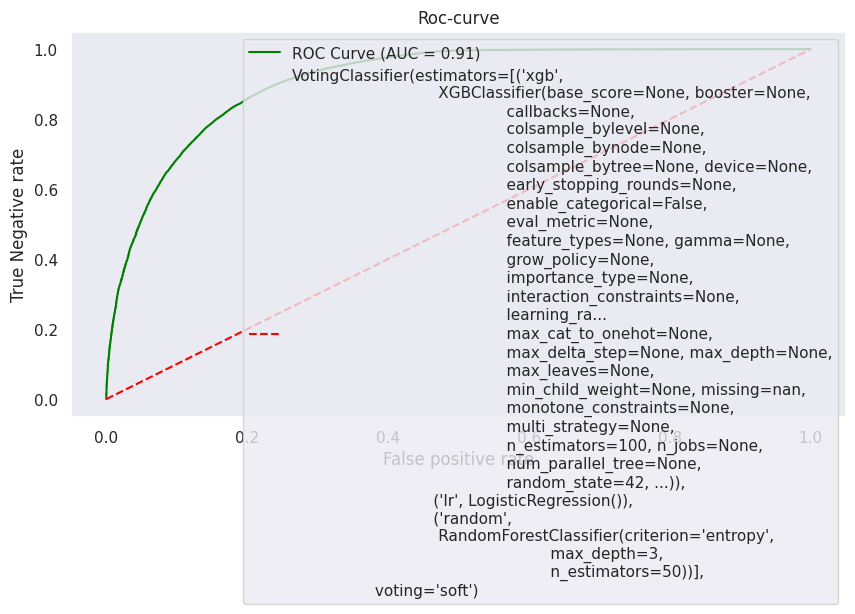

In [25]:
from imblearn.over_sampling import RandomOverSampler
over_sampler=RandomOverSampler(random_state=43)
X_ove,y_ove=over_sampler.fit_resample(X_train,y_train)

# Finally apply the VotingClassifer model
machine_learning_model(voting_model,X_ove,X_test,y_ove,y_test)

## Hyperparameter tuning to improve the score and F1-score
 ### Logistic Regression Model

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'fit_intercept': [True, False],
                         'max_iter': [20, 30, 50],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'sag']},
             scoring='balanced_accuracy') accuracy score is 0.767015266096068 

              precision    recall  f1-score   support

         0.0       0.45      0.71      0.55     30014
         1.0       0.91      0.78      0.84    118485

    accuracy                           0.77    148499
   macro avg       0.68      0.75      0.70    148499
weighted avg       0.82      0.77      0.78    148499
 



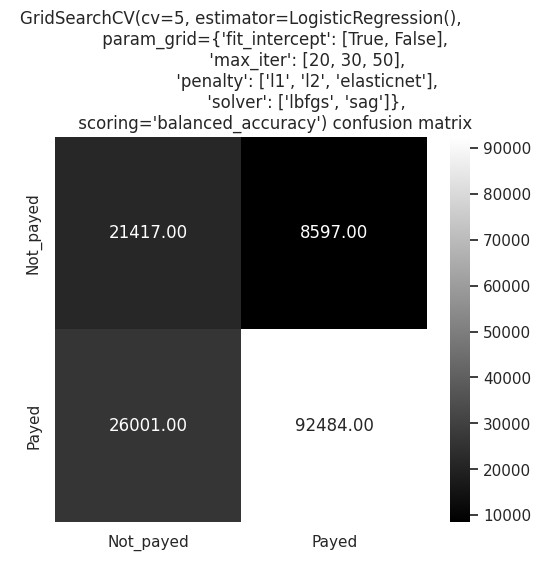

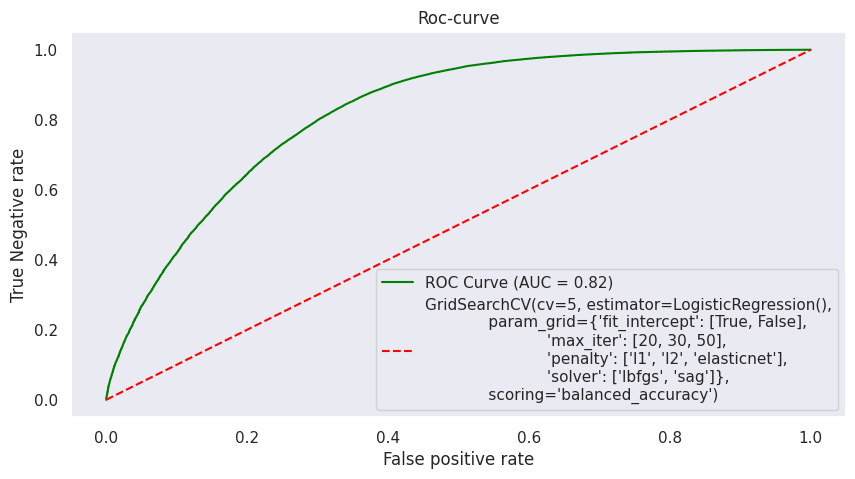

In [26]:
# Logistic Hyperparameters turning
param={
    'penalty':['l1','l2','elasticnet'],
    'fit_intercept':[True,False],
    'max_iter':[20,30,50],
    'solver':['lbfgs','sag']

}

logitic_grid=GridSearchCV(logistic,param_grid=param,scoring='balanced_accuracy',cv=5)

# Finally apply the LogisticRegression
machine_learning_model(logitic_grid,X_ove,X_test,y_ove,y_test)


 ### Decision Tree Classifier Hyperparameter turning

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(criterion='entropy', max_depth=3),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 8, 10, 15],
                         'splitter': ['best', 'random']},
             scoring='f1') accuracy score is 0.9018848611775163 

              precision    recall  f1-score   support

         0.0       0.89      0.58      0.71     30014
         1.0       0.90      0.98      0.94    118485

    accuracy                           0.90    148499
   macro avg       0.90      0.78      0.82    148499
weighted avg       0.90      0.90      0.89    148499
 



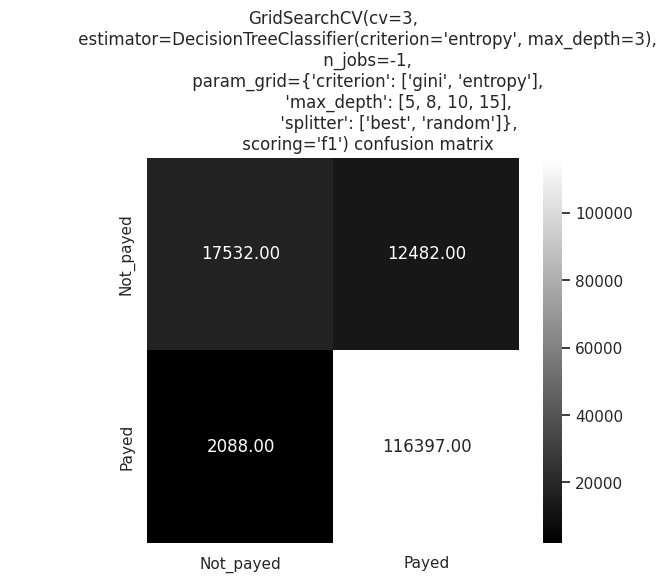

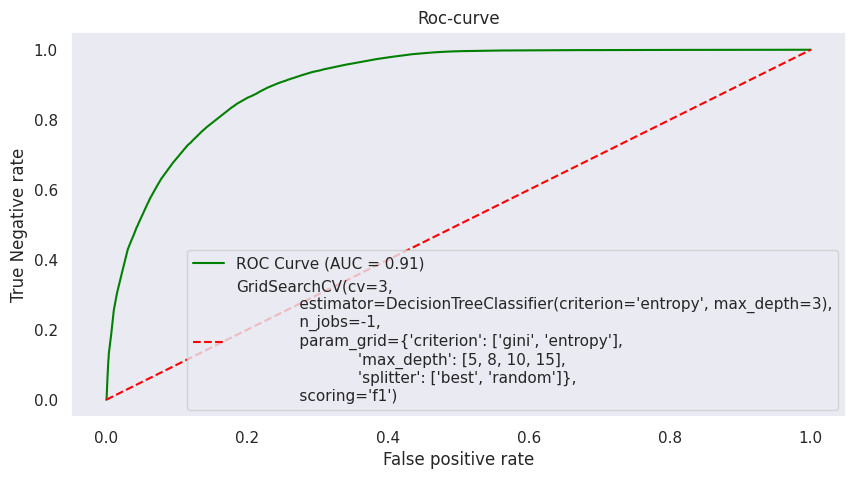

In [27]:
params={
    'criterion':["gini", "entropy"],
    'splitter':['best','random'],
    'max_depth':[5,8,10,15]
    
}
decision_grid=GridSearchCV(tree,param_grid=params,scoring='f1',cv=3,n_jobs=-1)

# Finally apply the DecisionTreeClassifier
machine_learning_model(decision_grid,X_train,X_test,y_train,y_test)

### RandomForest Classifier Hyperparameter turning

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(criterion='entropy', max_depth=3,
                                              n_estimators=50),
             n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [15],
                         'min_samples_split': [5], 'n_estimators': [70]},
             scoring='f1') accuracy score is 0.9024707237085772 

              precision    recall  f1-score   support

         0.0       0.90      0.58      0.71     30014
         1.0       0.90      0.98      0.94    118485

    accuracy                           0.90    148499
   macro avg       0.90      0.78      0.82    148499
weighted avg       0.90      0.90      0.89    148499
 



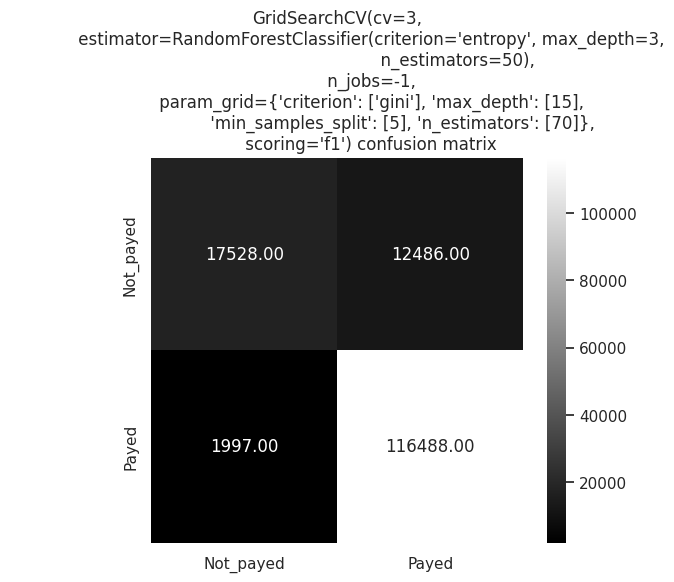

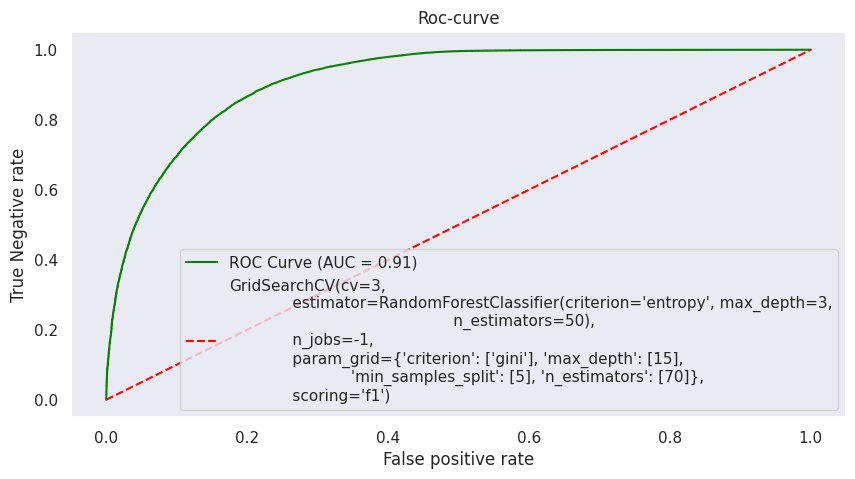

In [28]:
params={
    'n_estimators':[70],
    'criterion':["gini"],
    'min_samples_split':[5],
    'max_depth':[15]
    
}
random_grid=GridSearchCV(random,param_grid=params,scoring='f1',cv=3,n_jobs=-1)

# Finally, apply the RandomForest Classifier
machine_learning_model(random_grid,X_train,X_test,y_train,y_test)

### XGB Hyperparameter turning

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=2,
           

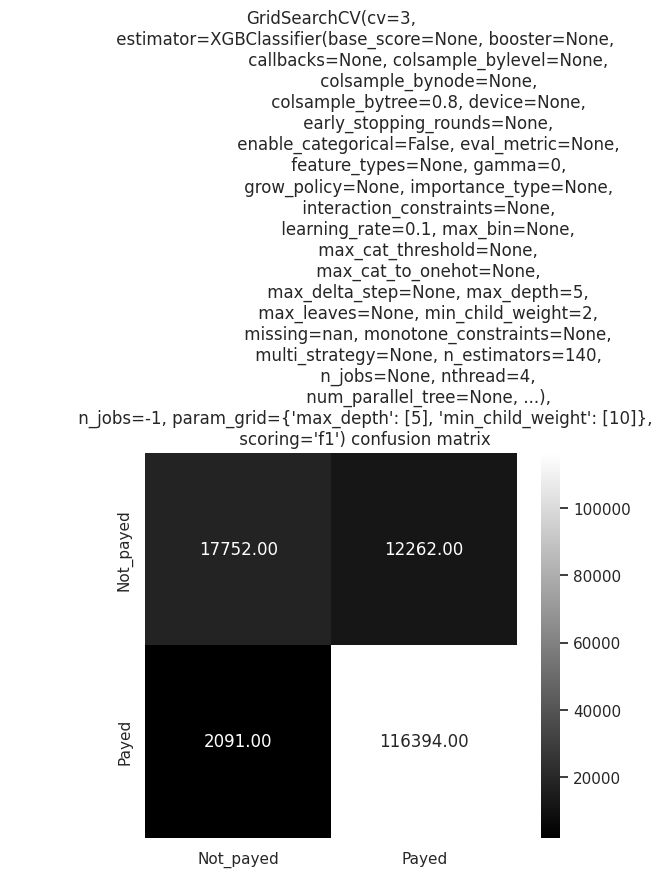

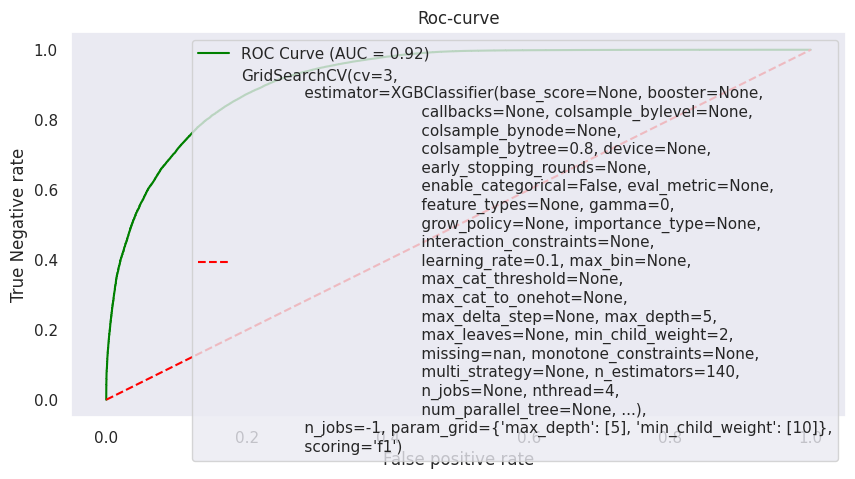

In [29]:
param = {
 'max_depth':[5],
 'min_child_weight':[10]
}
xgb_2= XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
xgb_grid=GridSearchCV(xgb_2,param_grid=param,scoring='f1',cv=3,n_jobs=-1)

# Finally, apply the RandomForest Classifier
machine_learning_model(xgb_grid,X_train,X_test,y_train,y_test)

## ⭐ 1. Use K-Fold Cross Validation

In [41]:
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score,StratifiedKFold

# Let's drop the correlation columns
train_corr=train_df.drop('grade_subgrade',axis=1)


# Split the dataset into X and y
X=train_corr.iloc[:,1:11]
y=train_corr.iloc[:,-1]
# create a function for the KFold
def kfload_model(model,X,y):
    
    kfload=StratifiedKFold(n_splits=5,shuffle= True,random_state=250)
    score=cross_val_score(model,X,y,cv=kfload,scoring='accuracy')
    model.fit(X,y)
    kfload_pred=model.predict(test_corr)
    # apply to the submission files

    sub_file['loan_paid_back']=kfload_pred

    # Save the file in csv format

    sub_file.to_csv(f'kfload_{model}_model.csv',index=False)
    
    print('Cv accuracy _score',score)
    print('Cv mean accuracy _score',score.mean())
kfload_model(ada_boost,X,y)

Cv accuracy _score [0.90058839 0.9002096  0.90254127 0.90089984 0.90153033]
Cv mean accuracy _score 0.9011538843430141


## ANN Model implementation

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import ReLU,LeakyReLU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping


# scaling the data
scaler=StandardScaler()

# Scaling the data
X_train_scal=scaler.fit_transform(X_train)

# Scaling the test data
X_train_test=scaler.transform(X_test)

# Ann model Bulding

ann_model=Sequential()

#Add the input layer
ann_model.add(Dense(units=10,activation='relu'))
ann_model.add(Dropout(0.3))

# Frist Layer
ann_model.add(Dense(units=11,activation='relu'))
ann_model.add(Dropout(0.2))

#Second layer
ann_model.add(Dense(units=40,activation='relu'))
ann_model.add(Dropout(0.4))

#Second layer
ann_model.add(Dense(units=60,activation='relu'))
ann_model.add(Dropout(0.5))

#Output layer
ann_model.add(Dense(units=1,activation='sigmoid'))

#Complie the model
ann_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['f1_score'])

# Early stopping function
early_stopping = EarlyStopping(
        monitor='val_loss', 
        min_delta=1,        
        patience=4,       
        verbose=1,       
        mode='min',
        restore_best_weights=True
    )
model=ann_model.fit(X_train_scal,y_train,validation_split=0.20,epochs=50,batch_size=35,callbacks=early_stopping)
model_history=model.history

In [ ]:
ann_pred=ann_model.predict(test_corr)
ann_pred=(ann_pred >0.5).astype(int)
ann_pred=ann_pred.flatten()
ann_pred

In [ ]:
# apply to the submission files

sub_file['loan_paid_back']=ann_pred

# Save the file in csv format

sub_file.to_csv('submision_ann.csv',index=False)